## object_tracking_from_video

In this notebook we apply object tracking using SORT to determine the motion of people in a video, and count the number of people crossing a line. The general idea and the video are taken from https://www.pyimagesearch.com/2018/08/13/opencv-people-counter/

In the video there are 6 people in total - 4 walk noth-south and 2 south-north

In [1]:
#!pip install -r requirements.txt

In [2]:
from pathlib import Path
import pandas as pd
import cv2
from IPython.display import Image
import deepstack.core as ds
import json
import numpy as np
from sort.sort import *

%matplotlib inline

videos = list(Path("video/").rglob("*.mp4"))
video_path = str(videos[0]) # use video 0
print(video_path)

video/people-18s.mp4


In [3]:
video_path

'video/people-18s.mp4'

Read the frames and write to a temp folder (contents are gitignored to keep repo small)

In [4]:
FRAME_SAMPLING = 5 # video is at 30 FPS so down sample to limit compute

In [5]:
vidcap = cv2.VideoCapture(video_path)
success, frame = vidcap.read()
count = 0
cv2.imwrite("tmp/frame%d.jpg" % count, frame)     # save frame as JPEG file  

True

In [6]:
frames = list(Path("tmp/").rglob("*.jpg"))
frame_path = str(frames[0])
print(frame_path)

tmp/frame0.jpg


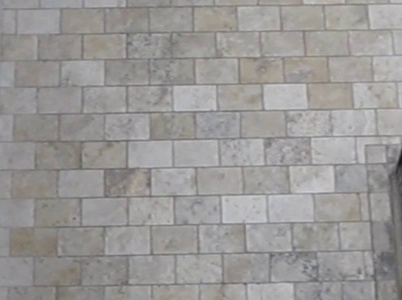

In [7]:
Image(frame_path)

Now iterate over all frames, saving if they are at the FRAME_SAMPLING. Use a list of dictionaries to keep info about the frames

In [8]:
results = []
true_count = 0 # in the original video
frame_count = 0 # in the sampled images

vidcap = cv2.VideoCapture(video_path)
success, frame = vidcap.read()

while success:  
    success, frame = vidcap.read()
    frame_path = f"tmp/frame_{frame_count}.jpg"
    
    if true_count % FRAME_SAMPLING == 0:
        cv2.imwrite(frame_path, frame)     # save frame as JPEG file    
        frame_info = {}
        frame_info['true_count'] = true_count
        frame_info['frame_count'] = frame_count
        frame_info['frame_path'] = frame_path
        results.append(frame_info)
        
        frame_count += 1
    true_count += 1

print(results[0])
print(len(results))

{'true_count': 0, 'frame_count': 0, 'frame_path': 'tmp/frame_0.jpg'}
107


## Process frames to extract object bounding boxes

In [9]:
# deepstack credentials
IP_ADDRESS = 'localhost'
PORT = 80
API_KEY =  "" # if you have not set an api_key, just pass an empty string
dsobject = ds.DeepstackObject(IP_ADDRESS, PORT, API_KEY)

In [10]:
%%time

for i, frame_info in enumerate(results):
    image = str(frame_info['frame_path'])
    try:
        with open(image, 'rb') as image_bytes:
            predictions = dsobject.detect(image_bytes)
            frame_info['predictions'] = predictions
            frame_info['persons'] = len([p for p in predictions if p['label']=='person'])
            print(f"Processing image number {i} : {image} : {frame_info['persons']} persons")
    except Exception as exc:
        print(exc)

Processing image number 0 : tmp/frame_0.jpg : 0 persons
Processing image number 1 : tmp/frame_1.jpg : 0 persons
Processing image number 2 : tmp/frame_2.jpg : 0 persons
Processing image number 3 : tmp/frame_3.jpg : 0 persons
Processing image number 4 : tmp/frame_4.jpg : 0 persons
Processing image number 5 : tmp/frame_5.jpg : 0 persons
Processing image number 6 : tmp/frame_6.jpg : 0 persons
Processing image number 7 : tmp/frame_7.jpg : 0 persons
Processing image number 8 : tmp/frame_8.jpg : 0 persons
Processing image number 9 : tmp/frame_9.jpg : 1 persons
Processing image number 10 : tmp/frame_10.jpg : 1 persons
Processing image number 11 : tmp/frame_11.jpg : 0 persons
Processing image number 12 : tmp/frame_12.jpg : 0 persons
Processing image number 13 : tmp/frame_13.jpg : 0 persons
Processing image number 14 : tmp/frame_14.jpg : 0 persons
Processing image number 15 : tmp/frame_15.jpg : 0 persons
Processing image number 16 : tmp/frame_16.jpg : 0 persons
Processing image number 17 : tmp/f

Write results to json for safekeeping

In [11]:
with open('results.json', 'w') as fp:
    json.dump(results, fp)

Extract the person count and visualise

In [12]:
persons = {p['frame_count']:p['persons'] for p in results}

Text(0, 0.5, 'Person count')

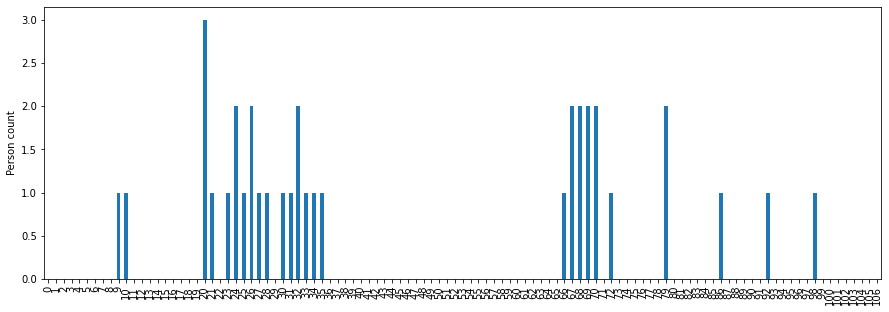

In [13]:
pd.Series(persons).plot.bar(figsize=(15,5)).set_ylabel('Person count')

This looks approximately correct but appears to be poor at identifying the individuals. We could use more frames to improve our chance of detection as maybe the sampled frames are not the best

## Track with sort
* https://towardsdatascience.com/detect-and-track-baseball-using-detectron2-and-sort-6dd92a46e6f2
* https://github.com/abewley/sort
Note I have just placed the contents of the sort repo in the folder `sort`

In [14]:
# !pip install -r sort/requirements.txt

Now we iterate over the frames, and for each frame pass in the bounding box coordinates, and get back the object tracked ID. 

* Sort expects a numpy array of detections in the format of `[[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],…]`
* Use `np.empty((0, 5))` for frames without detections

Write a helper to extract this info from result[10]

In [15]:
test_prediction = [{'confidence': 0.97203445,
   'label': 'person',
   'y_min': 0,
   'x_min': 104,
   'y_max': 108,
   'x_max': 162},
  {'confidence': 0.8538234,
   'label': 'person',
   'y_min': 2,
   'x_min': 185,
   'y_max': 84,
   'x_max': 235}]

In [16]:
test_prediction

[{'confidence': 0.97203445,
  'label': 'person',
  'y_min': 0,
  'x_min': 104,
  'y_max': 108,
  'x_max': 162},
 {'confidence': 0.8538234,
  'label': 'person',
  'y_min': 2,
  'x_min': 185,
  'y_max': 84,
  'x_max': 235}]

In [17]:
def get_detections(prediction : list) -> np.array:
    detections = []
    people = [p for p in prediction if p['label']=='person']
    if len(people) == 0:
        return np.empty((0, 5))
    for p in people:
        detection = np.array([p['x_min'], p['y_min'], p['x_max'], p['y_max'], p['confidence']])
        detections.append(detection)
    return np.array(detections)

get_detections(test_prediction)

array([[104.        ,   0.        , 162.        , 108.        ,
          0.97203445],
       [185.        ,   2.        , 235.        ,  84.        ,
          0.8538234 ]])

In [18]:
#create instance of SORT. Note that rerunning this cell increments the track id each time
mot_tracker = Sort()

for i, frame_info in enumerate(results):
    image = str(frame_info['frame_path'])
    detections = get_detections(frame_info['predictions'])
    track_bbs_ids = mot_tracker.update(detections)
    print(i, track_bbs_ids)

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 []
13 []
14 []
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 [[183.96008252  44.48918636 253.9329312  165.70161142   2.        ]]
26 [[187.51927306  63.42292068 260.85094848 187.80326276   2.        ]]
27 [[187.91299682  86.18878162 264.61184814 215.06813559   2.        ]]
28 [[184.38561766 105.32894448 261.83471226 226.89267335   2.        ]]
29 []
30 []
31 []
32 []
33 []
34 [[194.44007995 232.20141163 266.79182515 305.72407341   7.        ]]
35 [[195.91589067 250.91134354 262.48308501 307.04828682   7.        ]]
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 [[222.88807956 194.25703272 310.70742558 287.16672684   8.        ]]
70 [[303.4908146  189.9329321  373.6862038  269.61225669   9.        ]
 [220.52678672 170.09929987 310.26744733 275.23143929   8

Sort is identifying 4 unique people, but we know there are 6, try tweaking parameters